# Importing Libraries

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import glob

from sklearn import preprocessing
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
import pickle


import warnings
warnings.filterwarnings("ignore")

# Unzipping the File

In [ ]:
! unzip "/content/drive/MyDrive/Rice_classification/archive.zip" -d "/content/drive/MyDrive/Rice_classification"

In [23]:
base_link=r"/content/drive/MyDrive/Rice_classification/Rice_Image_Dataset"
classes=os.listdir(f"{base_link}")
rice_class=classes[0:5]
rice_class

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

# Creating and saving the Data Frame

In [24]:
image_link=list(Path(f"{base_link}").glob(r"**/*.jpg"))
image_name=[x.parents[0].stem for x in image_link]
image_label=preprocessing.LabelEncoder().fit_transform(image_name)
df=pd.DataFrame({"link":np.array(image_link,dtype="str"),
                 "name":image_name,
                 "label":image_label})

In [25]:
df.to_csv(r"/content/drive/MyDrive/Rice_classification/Rice_df",index=False)

In [26]:
df

,link,name,label
0,/content/drive/MyDrive/Rice_classification/Ric...,Arborio,0
1,/content/drive/MyDrive/Rice_classification/Ric...,Arborio,0
2,/content/drive/MyDrive/Rice_classification/Ric...,Arborio,0
3,/content/drive/MyDrive/Rice_classification/Ric...,Arborio,0
4,/content/drive/MyDrive/Rice_classification/Ric...,Arborio,0
...,...,...,...
74995,/content/drive/MyDrive/Rice_classification/Ric...,Karacadag,4
74996,/content/drive/MyDrive/Rice_classification/Ric...,Karacadag,4
74997,/content/drive/MyDrive/Rice_classification/Ric...,Karacadag,4
74998,/content/drive/MyDrive/Rice_classification/Ric...,Karacadag,4


# Data Exploration

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   link    75000 non-null  object
 1   name    75000 non-null  object
 2   label   75000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


Arborio      15000
Basmati      15000
Ipsala       15000
Jasmine      15000
Karacadag    15000
Name: name, dtype: int64


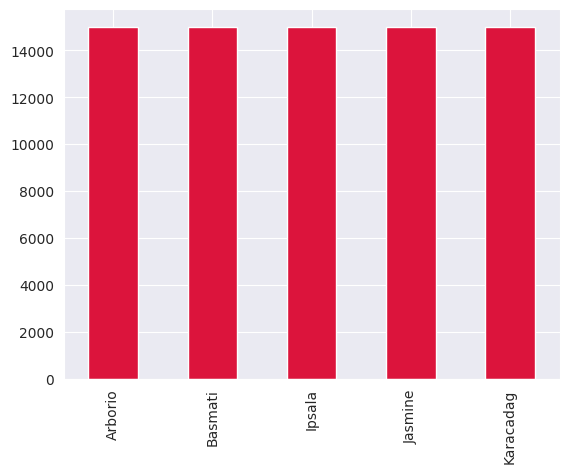

In [31]:
print(df.name.value_counts())
sns.set_style("darkgrid")
df.name.value_counts().plot(kind="bar",color="crimson")
plt.show()

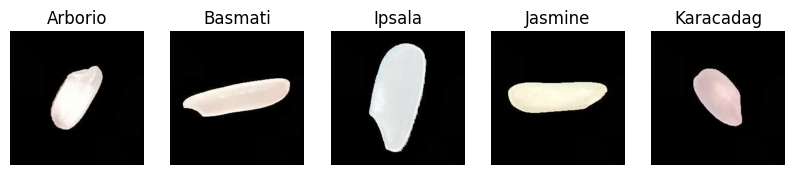

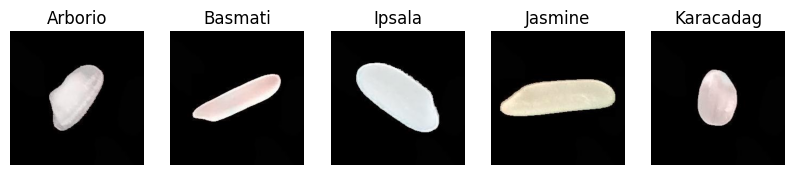

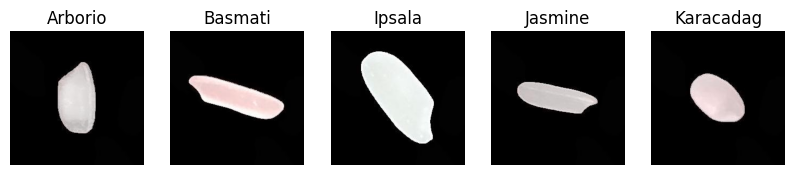

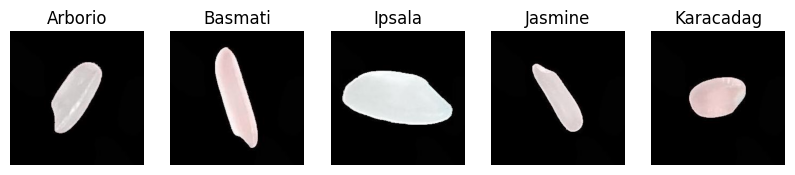

In [ ]:
def random_image(path,label):
  plt.figure(figsize=(10,10))

  i=0
  for label in rice_class:
    i+=1
    plt.subplot(1,5,i)
    file=np.random.choice(os.listdir(f'{path}/{label}'))
    image_path=os.path.join(f'{path}/{label}',file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis("off")

for i in range(4):
  random_image(base_link,rice_class)

# Data Preprocessing

In [32]:
#splitting the into trian and test
train,test=train_test_split(df,test_size=0.2,random_state=45)

train_datagen=ImageDataGenerator()
test_datagen=ImageDataGenerator()

train_df=train_datagen.flow_from_dataframe( train,
                      subset="training",
                       x_col="link",
                       y_col="name",
                      shuffle=False,
                      target_size=(100,100),
                      batch_size=32,
                      seed=42,
                      class_mode="categorical"
)
val_df=test_datagen.flow_from_dataframe( test,
                       #subset="validation",
                       x_col="link",
                       y_col="name",
                      shuffle=False,
                      target_size=(100,100),
                      batch_size=32,
                      seed=42,
                      class_mode="categorical"
)
test_df=test_datagen.flow_from_dataframe( test,
                       #subset="validation",
                       x_col="link",
                       y_col="name",
                      shuffle=False,
                      target_size=(100,100),
                      batch_size=32,
                      seed=42,
                      class_mode="categorical"
)

Found 60000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.


# Model Vanilla

In [33]:
model_cnn=Sequential()

model_cnn.add(Conv2D(15,(3,3),activation="relu",input_shape=(100,100,3)))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2,2)))

model_cnn.add(Conv2D(30,(3,3),activation="relu"))
model_cnn.add(BatchNormalization(axis=3))
model_cnn.add(MaxPooling2D(pool_size=(2,2)))

model_cnn.add(Dropout(0.3))

model_cnn.add(Flatten())

model_cnn.add(Dense(100,activation="relu"))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.5))

model_cnn.add(Dense(50,activation="relu"))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.5))

model_cnn.add(Dense(10,activation="relu"))
model_cnn.add(Dropout(0.25))

model_cnn.add(Dense(5,activation="softmax"))

model_cnn.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 98, 15)        420       
                                                                 
 batch_normalization_12 (Ba  (None, 98, 98, 15)        60        
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 49, 49, 15)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 30)        4080      
                                                                 
 batch_normalization_13 (Ba  (None, 47, 47, 30)        120       
 tchNormalization)                                               
                                                      

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)
checkpoint=ModelCheckpoint(filepath="../model_cnn.hdf5",mode="max",monitor="val_accuracy", verbose=1,save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)

callbacks=[early_stopping, checkpoint,reduce_lr]
history1=model_cnn.fit(train_df,epochs=10,validation_data=val_df,callbacks=callbacks)

Epoch 1/10
1875/1875 [==============================] - ETA: 0s - loss: 0.1081 - accuracy: 0.9639
Epoch 1: val_accuracy improved from -inf to 0.89620, saving model to ../model_cnn.hdf5
1875/1875 [==============================] - 162s 86ms/step - loss: 0.1081 - accuracy: 0.9639 - val_loss: 0.4401 - val_accuracy: 0.8962 - lr: 0.0010
Epoch 2/10
1875/1875 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.9657
Epoch 2: val_accuracy improved from 0.89620 to 0.94667, saving model to ../model_cnn.hdf5
1875/1875 [==============================] - 167s 89ms/step - loss: 0.1031 - accuracy: 0.9657 - val_loss: 0.1914 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 3/10
1875/1875 [==============================] - ETA: 0s - loss: 0.1378 - accuracy: 0.9549
Epoch 3: val_accuracy improved from 0.94667 to 0.97127, saving model to ../model_cnn.hdf5
1875/1875 [==============================] - 182s 97ms/step - loss: 0.1378 - accuracy: 0.9549 - val_loss: 0.0886 - val_accuracy: 0.9713 - lr:

In [37]:
#Model Evaluation
score1 = model_cnn.evaluate(test_df, verbose=1)

469/469 [==============================] - 29s 62ms/step - loss: 0.0534 - accuracy: 0.9855


In [39]:
# Defing the functions for plottin train History and model saving
def model_saved(model,model_path):
  pickle.dump(model,open(model_path,"wb"))


def plot_train_history(history):
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [41]:
#Saving the Vanilla Model
model_path="../model_cnn.pkl"
model_saved(model_cnn,model_path)

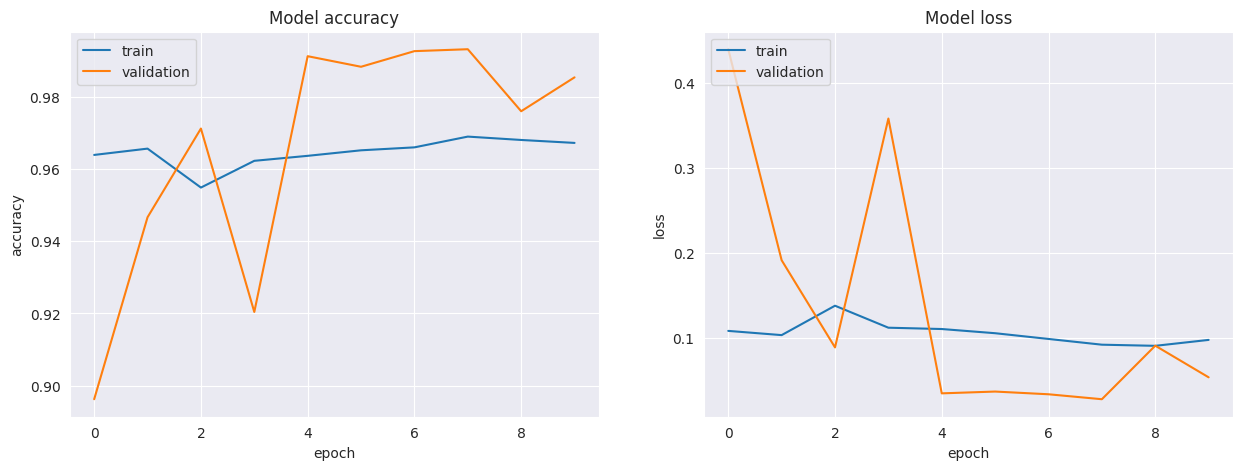

In [42]:
#Plotting the Training history of vanilla model
plot_train_history(history1)

# Transferring Learning of VGG16

In [43]:
vgg=VGG16(weights="imagenet",include_top=False,input_shape=(100,100,3))
vgg.trainable=False

model_vgg=Sequential([vgg])
model_vgg.add(Flatten())

model_vgg.add(Dense(75,activation="relu",kernel_initializer="random_uniform"))

model_vgg.add(Dense(15,activation="relu",kernel_initializer="random_uniform"))

model_vgg.add(Dense(5,activation="softmax",kernel_initializer="random_uniform"))


58889256/58889256 [==============================] - 2s 0us/step


In [44]:
model_vgg.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
model_vgg.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 4608)              0         
                                                                 
 dense_16 (Dense)            (None, 75)                345675    
                                                                 
 dense_17 (Dense)            (None, 15)                1140      
                                                                 
 dense_18 (Dense)            (None, 5)                 80        
                                                                 
Total params: 15061583 (57.46 MB)
Trainable params: 346895 (1.32 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [45]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)
checkpoint=ModelCheckpoint(filepath="../model_vgg.hdf5",mode="max",monitor="val_accuracy", verbose=1,save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)

callbacks=[early_stopping, checkpoint,reduce_lr]

In [46]:
history2=model_vgg.fit(train_df,validation_data=val_df,epochs=10,callbacks=callbacks)

Epoch 1/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9803
Epoch 1: val_accuracy improved from -inf to 0.98007, saving model to ../model_vgg.hdf5
1875/1875 [==============================] - 185s 97ms/step - loss: 0.0603 - accuracy: 0.9803 - val_loss: 0.0665 - val_accuracy: 0.9801 - lr: 0.0010
Epoch 2/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9906
Epoch 2: val_accuracy improved from 0.98007 to 0.98640, saving model to ../model_vgg.hdf5
1875/1875 [==============================] - 177s 94ms/step - loss: 0.0300 - accuracy: 0.9906 - val_loss: 0.0422 - val_accuracy: 0.9864 - lr: 0.0010
Epoch 3/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 0.9928
Epoch 3: val_accuracy improved from 0.98640 to 0.99173, saving model to ../model_vgg.hdf5
1875/1875 [==============================] - 172s 92ms/step - loss: 0.0226 - accuracy: 0.9928 - val_loss: 0.0295 - val_accuracy: 0.9917 - lr:

In [47]:
#Model Evaluation
score2 = model_vgg.evaluate(test_df, verbose=1)

469/469 [==============================] - 33s 69ms/step - loss: 0.0286 - accuracy: 0.9917


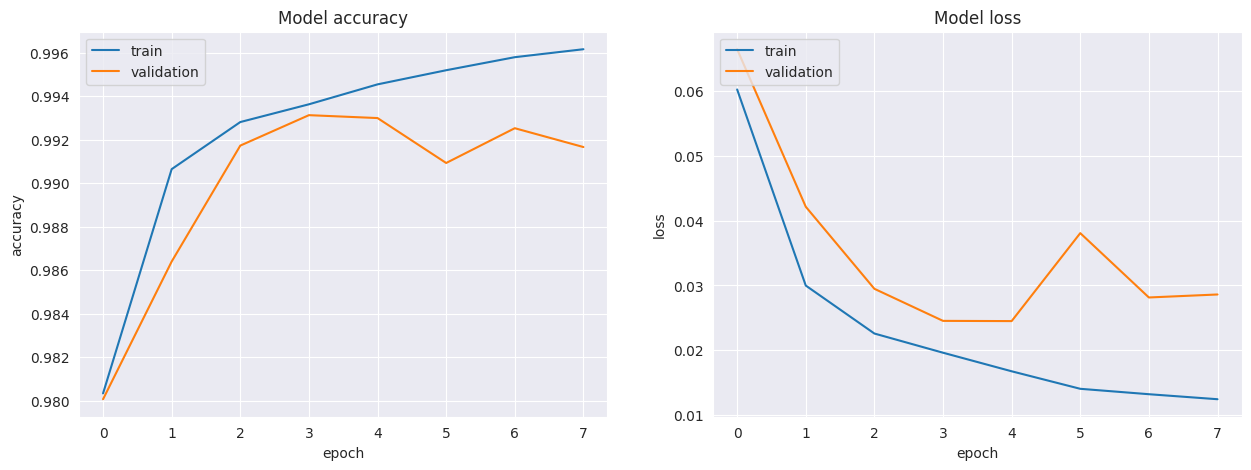

In [48]:
#Plotting training the History before fine tuning
plot_train_history(history2)

In [49]:
#Saving the model without Fine Tuning
model_path="../model_vgg.pkl"
model_saved(model_vgg,model_path)

# Fine Tuning

In [54]:
vgg.trainable=True
model_vgg.compile(optimizer=keras.optimizers.Adam(1e-5),loss="categorical_crossentropy",metrics=["accuracy"])

In [55]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
checkpoint=ModelCheckpoint(filepath="../model_vgg_tune.hdf5",mode="max",monitor="val_accuracy", verbose=1,save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)

callbacks=[early_stopping, checkpoint,reduce_lr]

In [56]:
#Training the Model with Fine Tuning
history3=model_vgg.fit(train_df,validation_data=val_df,epochs=10,callbacks=callbacks)

Epoch 1/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.9925
Epoch 1: val_accuracy improved from -inf to 0.99760, saving model to ../model_vgg_tune.hdf5
1875/1875 [==============================] - 254s 131ms/step - loss: 0.0269 - accuracy: 0.9925 - val_loss: 0.0101 - val_accuracy: 0.9976 - lr: 1.0000e-05
Epoch 2/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9967
Epoch 2: val_accuracy did not improve from 0.99760
1875/1875 [==============================] - 241s 128ms/step - loss: 0.0125 - accuracy: 0.9967 - val_loss: 0.0136 - val_accuracy: 0.9963 - lr: 1.0000e-05
Epoch 3/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9971
Epoch 3: val_accuracy improved from 0.99760 to 0.99900, saving model to ../model_vgg_tune.hdf5
1875/1875 [==============================] - 241s 129ms/step - loss: 0.0092 - accuracy: 0.9971 - val_loss: 0.0057 - val_accuracy: 0.9990 - lr: 1.0000e-05
Epoch 

In [57]:
#Evaluating the Model
score3 = model_vgg.evaluate(test_df, verbose=1)

469/469 [==============================] - 33s 70ms/step - loss: 0.0063 - accuracy: 0.9989


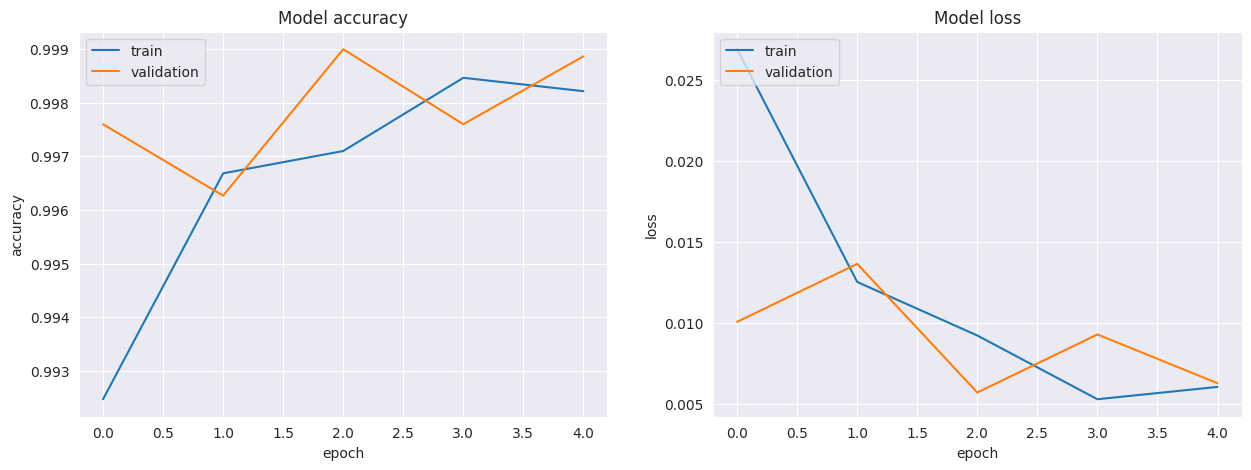

In [58]:
#Plotting Training History after Fine Tuning
plot_train_history(history3)

In [59]:
#Saving the model
model_path="../model_vgg_tune.pkl"
model_saved(model_vgg,model_path)

# Comparision and Prediction of Models

In [71]:
def confusio_matrix(y_pred,test_df):

  confusion_mtx = confusion_matrix(y_pred, test_df.classes)
  f,ax = plt.subplots(figsize=(7,7))
  sns.heatmap(confusion_mtx, annot=True,
  linewidths=0.01,
  linecolor="white",
  fmt= '.1f',ax=ax,cmap="coolwarm")

  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  ax.xaxis.set_ticklabels(test_df.class_indices)

  ax.yaxis.set_ticklabels(rice_class)
  plt.title("Confusion Matrix")
  plt.show()

In [81]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred_cnn = model_cnn.predict(test_df)
y_pred_cnn = np.argmax(Y_pred_cnn, axis=1)

469/469 [==============================] - 29s 62ms/step


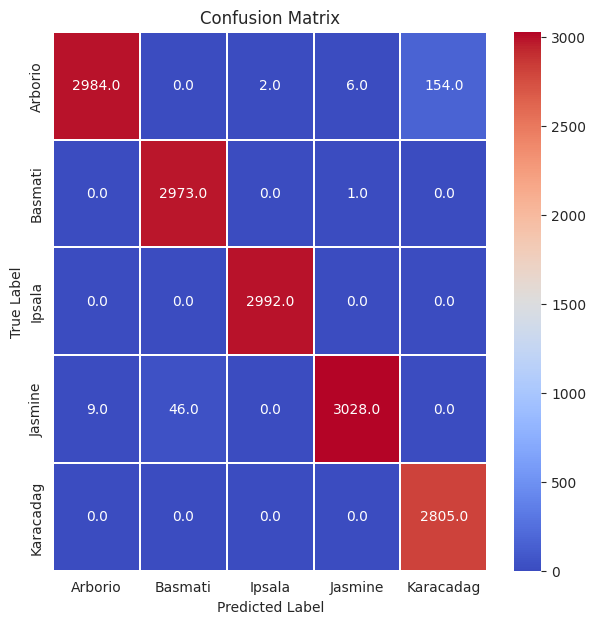

In [73]:
confusio_matrix(y_pred,test_df)

469/469 [==============================] - 30s 65ms/step


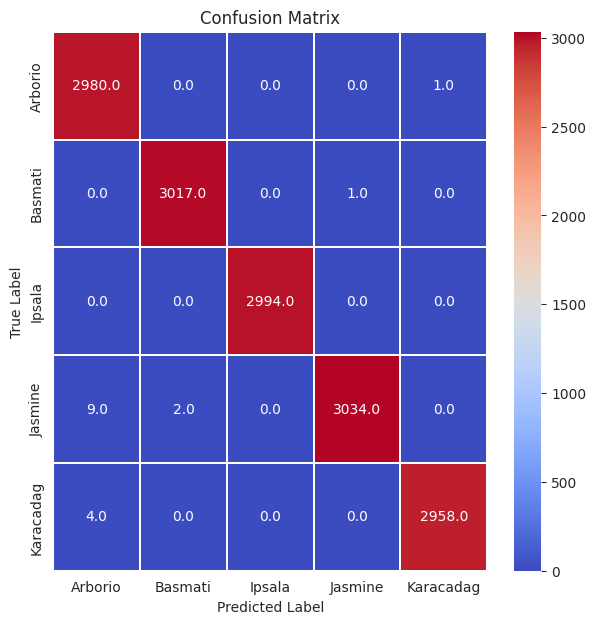

In [82]:
Y_pred_vgg = model_vgg.predict(test_df)
y_pred_vgg = np.argmax(Y_pred_vgg, axis=1)
confusio_matrix(y_pred,test_df)

In [76]:
print(f'Model 1 Vanilla Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'Model 2 VGG16 Loss: {score2[0]}, Accuracy: {score2[1]*100}')
print(f'Model 2 VGG16 Fine-tuned Loss: {score3[0]}, Accuracy: {score3[1]*100}')

Model 1 Vanilla Loss: 0.0533861480653286, Accuracy: 98.54666590690613
Model 2 VGG16 Loss: 0.02859933115541935, Accuracy: 99.16666746139526
Model 2 VGG16 Fine-tuned Loss: 0.006275699008256197, Accuracy: 99.88666772842407


In [86]:
report1 = classification_report(test_df.classes, y_pred_cnn, target_names=rice_class, output_dict=True)
df1 = pd.DataFrame(report1).transpose()



report2 = classification_report(test_df.classes, y_pred_vgg, target_names=rice_class, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
print("Classification Report of Vanilla Model:\n",df1,"\n\nClassification Report of Transfer Learning Model:\n",df2)

Classification Report of Vanilla Model:
               precision    recall  f1-score       support
Arborio        0.948506  0.996993  0.972145   2993.000000
Basmati        0.999664  0.984763  0.992158   3019.000000
Ipsala         1.000000  0.999332  0.999666   2994.000000
Jasmine        0.982160  0.997694  0.989866   3035.000000
Karacadag      1.000000  0.947955  0.973282   2959.000000
accuracy       0.985467  0.985467  0.985467      0.985467
macro avg      0.986066  0.985347  0.985423  15000.000000
weighted avg   0.986048  0.985467  0.985476  15000.000000 

Classification Report of Transfer Learning Model:
               precision    recall  f1-score       support
Arborio        0.999665  0.995657  0.997657   2993.000000
Basmati        0.999669  0.999338  0.999503   3019.000000
Ipsala         1.000000  1.000000  1.000000   2994.000000
Jasmine        0.996388  0.999671  0.998026   3035.000000
Karacadag      0.998650  0.999662  0.999156   2959.000000
accuracy       0.998867  0.998867  0

# Conclusion:-
1. On basis of metrics both models Performing well.
2. Transfer Learning VGG16 model predicts 99.88 % of accuracy where as Model Vanilla predicts 98.54 of accuracy.
3. We can Deploy the both models.